# pytorchを使ったデータ読み込み処理

In [59]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets

plt.ion()

- faceフォルダには顔写真69枚と各写真の特徴点のCSVファイルが含まれている
- CSVファイルをpandasで読み込み、画像ファイルはskimageのioで読み込む

In [2]:
landmarks_frame = pd.read_csv('faces/face_landmarks.csv')

In [29]:
print(landmarks_frame.shape)
landmarks_frame.head()

(69, 137)


,image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x,part_2_y,part_3_x,part_3_y,part_4_x,...,part_63_x,part_63_y,part_64_x,part_64_y,part_65_x,part_65_y,part_66_x,part_66_y,part_67_x,part_67_y
0,0805personali01.jpg,27,83,27,98,29,113,33,127,39,...,93,136,100,141,93,135,89,135,84,134
1,1084239450_e76e00b7e7.jpg,70,236,71,257,75,278,82,299,90,...,148,311,179,308,149,312,137,314,128,312
2,10comm-decarlo.jpg,66,114,65,128,67,142,68,156,72,...,128,162,136,167,127,166,121,165,116,164
3,110276240_bec305da91.jpg,42,140,45,161,51,180,61,200,73,...,144,197,180,189,147,204,136,208,125,209
4,1198_0_861.jpg,138,392,141,427,145,464,152,501,166,...,293,507,331,511,294,516,279,518,265,516


In [6]:
# サンプルに1枚の画像を読み込み、特徴点にマッピング
n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].as_matrix()
landmarks = landmarks.astype('float').reshape(-1, 2) # すべての特徴点のx,yのペアのリストに整形

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


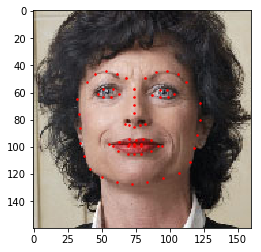

In [14]:
def show_landmarks(image, landmarks):
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)

plt.figure()
show_landmarks(io.imread(os.path.join('faces/', img_name)), landmarks)
plt.show()

### ※pytorchでオリジナルのデータを使用する場合はDatasetオブジェクトにする必要がある.
ここでは以下の処理を行う  

1. Datasetクラスを継承
2. __len__と__getitem__メソッドをオーバライド
3. __init__でCSVを開く処理を、__getitem__で都度データを呼び出し
4. {'image': imgage, 'landmarks': landmarks}の辞書を作成。また、後述のtransformを導入

In [25]:
class FaceLandmarksDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.landmarks_frame)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix()
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}
        
        if self.transform:
            sample = self.transform(sample)
        return sample

0 (324, 215, 3) (68, 2)


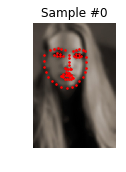

1 (500, 333, 3) (68, 2)


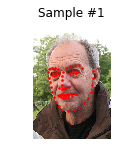

2 (250, 258, 3) (68, 2)


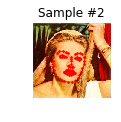

3 (434, 290, 3) (68, 2)


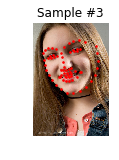

In [27]:
# 任意の枚数（ここでは3枚）を取り出して、特徴点を重ねて表示
face_dataset = FaceLandmarksDataset(csv_file='./faces/face_landmarks.csv', root_dir='./faces/')
fig = plt.figure()
for i in range(len(face_dataset)):
    sample = face_dataset[i]
    print(i, sample['image'].shape, sample['landmarks'].shape)
    ax = plt.subplot(1, 4, i+1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)
    if i == 3:
        plt.show()
        break

## 次に画像に対する前処理を行う.
ここでもいかの処理を行う  
1. Rescale: 画像をリスケール
2. RandomCrop: ランダムに画像を切り抜き、水増しさせる
3. **ToTensor**: pytorchで処理できる型へ変換

In [37]:
class Rescale():
    """
    与えられたshapeに従って画像を変更
    
    Args:
        output_size(int or tupple): タプルの場合はそのまま画像のshapeとする。
            intの場合は（縦と横）短い辺をoutput_sizeに合わせ、その時のアスペクト比に従って長い辺を変更する
    """
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
    
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        new_h, new_w = int(new_h), int(new_w)
        img = transform.resize(image, (new_h, new_w))
        landmarks = landmarks * [new_w / w, new_h / h]
        return {'image': img, 'landmarks': landmarks}

In [38]:
class RandomCrop():
    """
    与えられたshapeの幅をランダムな位置に配置し、画像をreshapeする
    """
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
    
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        top = np.random.randint(0, h-new_h)
        left = np.random.randint(0, w-new_w)
        image = image[top: top+new_h,
                      left: left+new_w]
        landmarks = landmarks - [left, top]
        return {'image': image, 'landmarks': landmarks}

In [48]:
class ToTensor():
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image), 'landmarks': torch.from_numpy(landmarks)}

/Users/moriyama/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


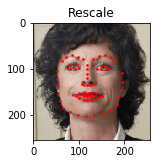

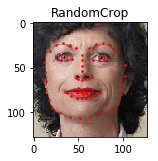

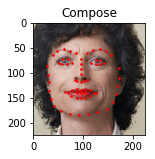

In [49]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256), RandomCrop(224)])

fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)
    ax = plt.subplot(1, 3, i+1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)
plt.show()

## データのイテレーション

- 画像を1枚ずつ読み込み
- 変換
- 水増ししながらスライスしていく

for文で行う場合、バッチ処理やデータのシャッフル、並列実行が難しくなる。   
torch.utils.data.DataLoaderを用いることでパラメータに基づきデータのイテレーションが簡易になる。

In [50]:
transformed_dataset = FaceLandmarksDataset(csv_file='faces/face_landmarks.csv',
                                           root_dir='faces/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))


dataloader = DataLoader(transformed_dataset, batch_size=4, shuffle=True, num_workers=4)

In [57]:
def show_landmarks_batch(sample_batched):
    images_batch, landmarks_batch = sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    
    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    
    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r')
        plt.title('Batch from dataloader')

/Users/moriyama/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/moriyama/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/moriyama/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/moriyama/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.

0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


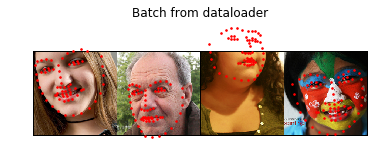

In [58]:
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(), sample_batched['landmarks'].size())
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

torchvisionには上記のような処理が実装されており、データセットの実装はImageFolderがある

In [63]:
data_transform = transforms.Compose([transforms.RandomSizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])



/Users/moriyama/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/torchvision/transforms/transforms.py:563: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  "please use transforms.RandomResizedCrop instead.")


RuntimeError: Found 0 files in subfolders of: ./faces/
Supported extensions are: .jpg,.jpeg,.png,.ppm,.bmp,.pgm,.tif